In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score,accuracy_score, confusion_matrix, classification_report
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
import seaborn as sns
from pprint import pprint
from sklearn.feature_selection import mutual_info_regression

In [2]:
# Load datasets
global_df = pd.read_csv(r'F:\ANC\Assignments\Achini\Global.csv')
landslide_df = pd.read_csv(r'F:\ANC\Assignments\Achini\landslide.csv')
landslide_data_df = pd.read_csv(r'F:\ANC\Assignments\Achini\landslide_data.csv')

#rename landslide to landslide prob
landslide_data_df.rename(columns={'Landslide': 'Landslide_prob'}, inplace=True)

# Display the first few rows of each dataset
print(global_df.head())
print(landslide_df.head())
print(landslide_data_df.head())

                                         the_geom  OBJECTID    id  \
0    POINT (-73.40200000000006 41.55850000000008)         1  3177   
1   POINT (113.91710000000012 0.1115000000000351)         2   490   
2   POINT (-127.69800000000009 52.35450000000008)         3  6760   
3   POINT (-127.50620000000009 50.70530000000013)         4  2494   
4  POINT (-132.41490000000013 53.331900000000125)         5  6415   

                          date_                         time_        country  \
0  03/07/2011 08:00:00 AM +0000  12/30/1899 08:00:00 AM +0000  United States   
1  04/01/2008 07:00:00 AM +0000                           NaN      Indonesia   
2  01/30/2015 08:00:00 AM +0000  12/30/1899 08:00:00 AM +0000            NaN   
3  09/24/2010 07:00:00 AM +0000                           NaN         Canada   
4  08/31/2014 07:00:00 AM +0000  12/30/1899 08:00:00 AM +0000            NaN   

                                          nearest_pl hazard_typ landslide_  \
0  Grove Street from Ander

In [5]:
# Extract features from Global dataset
global_features = global_df[['latitude', 'longitude']]

# Extract features from Landslide dataset
landslide_features = landslide_df[[ 'Moisture', 'temperature', 'humidity', 'rainfall']]

# Extract features from Landslide_data dataset
landslide_data_features = landslide_data_df[['Landslide_prob','Aspect', 'Curvature', 'Elevation', 'Precipitation', 'Slope','Earthquake', 'Lithology' ]]


In [9]:

# Combine features into a single DataFrame
combined_features = pd.concat([global_features.reset_index(drop=True),
                               landslide_features.reset_index(drop=True),
                               landslide_data_features.reset_index(drop=True)], axis=1)

# Clean the combined dataframe by removing NaN values
combined_features_cleaned = combined_features.dropna().reset_index(drop=True)


combined_features_cleaned.head(10)


,latitude,longitude,Moisture,temperature,humidity,rainfall,Landslide_prob,Aspect,Curvature,Elevation,Precipitation,Slope,Earthquake,Lithology
0,41.5585,-73.4020,0.36,20.879744,82.002744,202.935536,0.0,3.0,3.0,2.0,3.0,2.0,2.0,1.0
1,0.1115,113.9171,0.34,23.223974,83.033227,221.209196,0.0,1.0,5.0,3.0,5.0,2.0,2.0,1.0
2,52.3545,-127.6980,0.27,23.359054,83.595123,188.413665,0.0,3.0,4.0,2.0,5.0,2.0,3.0,4.0
3,50.7053,-127.5062,0.50,23.884048,86.206138,108.312179,0.0,1.0,3.0,3.0,5.0,3.0,3.0,1.0
4,53.3319,-132.4149,0.50,29.367924,76.249001,92.828409,0.0,5.0,4.0,1.0,3.0,4.0,2.0,1.0
5,50.4335,-127.4846,0.50,27.333690,83.676752,101.049479,0.0,5.0,5.0,2.0,3.0,2.0,2.0,1.0
6,61.9780,-143.1680,0.50,27.400536,82.962213,104.937800,0.0,1.0,3.0,2.0,5.0,2.0,2.0,1.0
7,50.5854,-127.0961,0.50,29.315908,80.115857,90.109781,0.0,3.0,5.0,4.0,5.0,4.0,3.0,2.0
8,50.9975,-126.4039,0.50,26.054330,79.396545,113.229737,0.0,3.0,2.0,3.0,5.0,4.0,3.0,6.0
9,1.3542,116.3816,0.50,25.866324,84.423793,114.535750,0.0,1.0,4.0,2.0,5.0,4.0,3.0,1.0


In [10]:
# Separate features and target variable
X = combined_features_cleaned.drop(columns=['Landslide_prob'])
y = combined_features_cleaned['Landslide_prob']

# Define preprocessing for numerical and categorical features
numeric_features = X.select_dtypes(include=['int64', 'float64']).columns
categorical_features = X.select_dtypes(include=['uint8']).columns

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define preprocessing for numerical and categorical features
numeric_features = X.select_dtypes(include=['int64', 'float64']).columns
categorical_features = X.select_dtypes(include=['object']).columns

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

print("Spliting data and Defining preprocessing is completed")

Spliting data and Defining preprocessing is completed


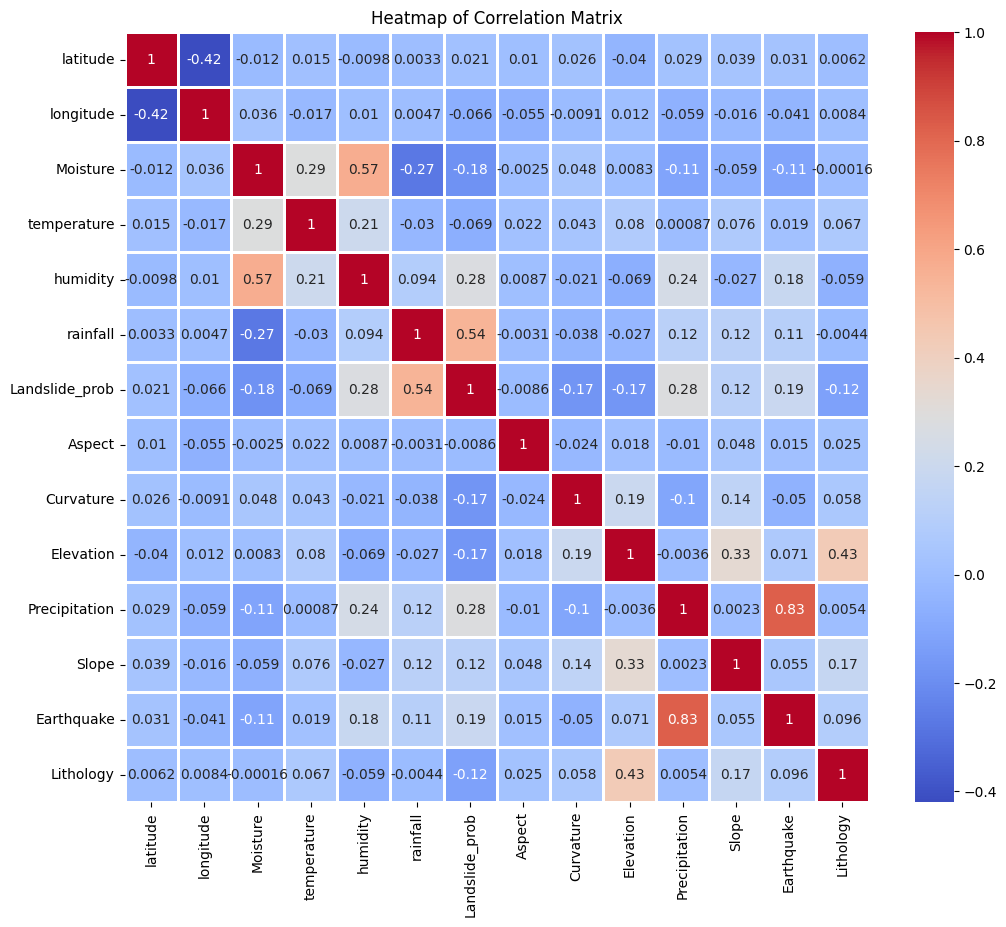

In [12]:
# Calculate the correlation matrix
corr_matrix = combined_features.corr()

# Create a heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', linewidths=0.9)
plt.title('Heatmap of Correlation Matrix')
plt.show()

In [13]:
# Extract features with high correlation with the target variable
correlation_threshold = 0.1  # Set a threshold for correlation
correlation_features = corr_matrix['Landslide_prob'][corr_matrix['Landslide_prob'].abs() > correlation_threshold].index.tolist()
correlation_features.remove('Landslide_prob')

# Prepare data for correlation-based feature selection
X_corr = X[correlation_features]
y_corr = y

# Split the data into training and testing sets
X_corr_train, X_corr_test, y_corr_train, y_corr_test = train_test_split(X_corr, y_corr, test_size=0.2, random_state=42)

# Define preprocessing for numerical features
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())])

# Define preprocessing for categorical features
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

# Identify numerical and categorical features for correlation-based dataset
numeric_features_corr = X_corr.select_dtypes(include=['int64', 'float64']).columns
categorical_features_corr = X_corr.select_dtypes(include=['uint8']).columns

# Preprocessor for correlation-based dataset
preprocessor_corr = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features_corr),
        ('cat', categorical_transformer, categorical_features_corr)])

# Define models
models = {
    'Random Forest': RandomForestRegressor(),
    'XGBoost': XGBRegressor(),
    'KNN': KNeighborsRegressor(),
    'SVR': SVR(),
    'Linear Regression': LinearRegression()
}

# Function to evaluate models
def evaluate_models(X_train, X_test, y_train, y_test, preprocessor):
    results = {}
    for name, model in models.items():
        pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('model', model)])
        pipeline.fit(X_train, y_train)
        
        y_pred = pipeline.predict(X_test)
        y_pred_class = (y_pred >= 0.5).astype(int)
        y_test_class = (y_test >= 0.5).astype(int)
        
        results[name] = {
            'MAE': mean_absolute_error(y_test, y_pred),
            'MSE': mean_squared_error(y_test, y_pred),
            'R2': r2_score(y_test, y_pred),
            'Accuracy': accuracy_score(y_test_class,y_pred_class)
            
        }
        
    return results

# Evaluate models using correlation-based features
results_corr = evaluate_models(X_corr_train, X_corr_test, y_corr_train, y_corr_test, preprocessor_corr)

# Display the results
print("Results using Correlation-based Features")
pprint(results_corr)


Results using Correlation-based Features
{'KNN': {'Accuracy': 0.897119341563786,
         'MAE': 0.157201646090535,
         'MSE': 0.0837860082304527,
         'R2': 0.6585590062111801},
 'Linear Regression': {'Accuracy': 0.8518518518518519,
                       'MAE': 0.2881877105659778,
                       'MSE': 0.11523721863825863,
                       'R2': 0.5303904400710466},
 'Random Forest': {'Accuracy': 0.934156378600823,
                   'MAE': 0.09584362139917695,
                   'MSE': 0.05436995884773663,
                   'R2': 0.7784339751552796},
 'SVR': {'Accuracy': 0.9382716049382716,
         'MAE': 0.18674782528377315,
         'MSE': 0.06505715624275403,
         'R2': 0.7348819862678825},
 'XGBoost': {'Accuracy': 0.934156378600823,
             'MAE': 0.09981605476454722,
             'MSE': 0.05070005645220764,
             'R2': 0.7933893972776805}}


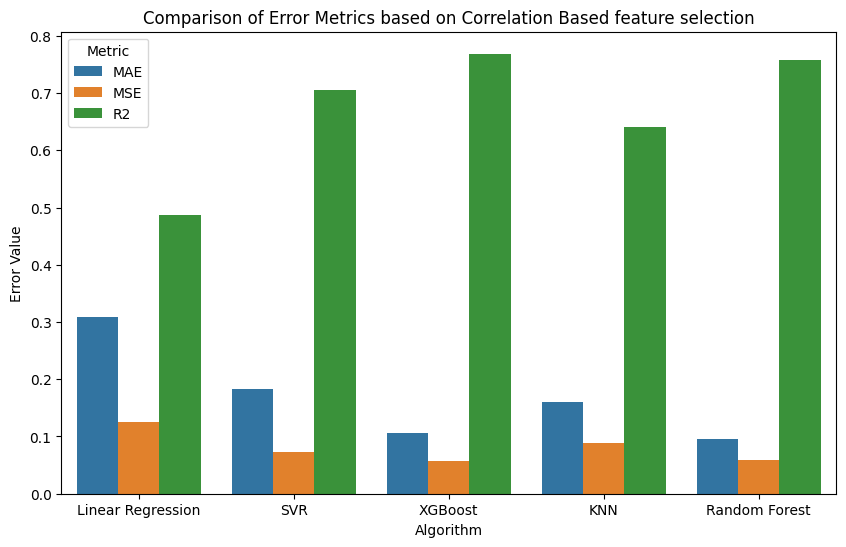

In [14]:
# Metrics dictionary populated from model evaluations
metrics = {
    'Algorithm': ['Linear Regression', 'SVR', 'XGBoost', 'KNN', 'Random Forest'],
    'MAE': [0.3091534640160717,0.1836056087216555,0.10523756275028505,0.16049382716049382, 0.09613168724279836],  
    'MSE': [0.12602038891029557,0.07223897259258263,0.05672580029908608,0.0880658436213992,0.05925349794238684],  
    'R2': [0.4864473468071744,0.7056149694534568,0.7688335554271405,0.6411180124223601,0.7585327950310559]    
}

# Convert the metrics dictionary to a DataFrame
metrics_df = pd.DataFrame(metrics)

# Melt the DataFrame for easier plotting
metrics_melted = metrics_df.melt(id_vars='Algorithm', var_name='Metric', value_name='Value')

# Create the bar graph
plt.figure(figsize=(10, 6))
sns.barplot(data=metrics_melted, x='Algorithm', y='Value', hue='Metric')
plt.title('Comparison of Error Metrics based on Correlation Based feature selection')
plt.ylabel('Error Value')
plt.xlabel('Algorithm')
plt.legend(title='Metric')
plt.show()

In [15]:
# Calculate Mutual Information
mutual_info = mutual_info_regression(X, y)
mutual_info_series = pd.Series(mutual_info, index=X.columns).sort_values(ascending=False)

# Select features based on mutual information
mutual_info_threshold = 0.1  # Set a threshold for mutual information
mutual_info_features = mutual_info_series[mutual_info_series > mutual_info_threshold].index.tolist()

# Prepare data for mutual information-based feature selection
X_mi = X[mutual_info_features]
y_mi = y

# Split the data into training and testing sets
X_mi_train, X_mi_test, y_mi_train, y_mi_test = train_test_split(X_mi, y_mi, test_size=0.2, random_state=42)

# Define preprocessing for numerical features
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())])

# Define preprocessing for categorical features
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

# Identify numerical and categorical features for mutual information-based dataset
numeric_features_mi = X_mi.select_dtypes(include=['int64', 'float64']).columns
categorical_features_mi = X_mi.select_dtypes(include=['uint8']).columns

# Preprocessor for mutual information-based dataset
preprocessor_mi = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features_mi),
        ('cat', categorical_transformer, categorical_features_mi)])

# Define models
models = {
    'Random Forest': RandomForestRegressor(),
    'XGBoost': XGBRegressor(),
    'KNN': KNeighborsRegressor(),
    'SVR': SVR(),
    'Linear Regression': LinearRegression()
}

# Function to evaluate models
def evaluate_models(X_train, X_test, y_train, y_test, preprocessor):
    results = {}
    for name, model in models.items():
        pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('model', model)])
        pipeline.fit(X_train, y_train)
        
        y_pred = pipeline.predict(X_test)
        y_pred_class = (y_pred >= 0.5).astype(int)
        y_test_class = (y_test >= 0.5).astype(int)
        
        results[name] = {
            'MAE': mean_absolute_error(y_test, y_pred),
            'MSE': mean_squared_error(y_test, y_pred),
            'R2': r2_score(y_test, y_pred),
            'Accuracy': accuracy_score(y_test_class,y_pred_class)
        }
        
    return results

# Evaluate models using mutual information-based features
results_mi = evaluate_models(X_mi_train, X_mi_test, y_mi_train, y_mi_test, preprocessor_mi)

# Display the results
print("Results using Mutual Information-based Features")
pprint(results_mi)

Results using Mutual Information-based Features
{'KNN': {'Accuracy': 0.9012345679012346,
         'MAE': 0.1259259259259259,
         'MSE': 0.0745679012345679,
         'R2': 0.6961242236024845},
 'Linear Regression': {'Accuracy': 0.8148148148148148,
                       'MAE': 0.3216096072324951,
                       'MSE': 0.13587933898326518,
                       'R2': 0.4462705943669547},
 'Random Forest': {'Accuracy': 0.9094650205761317,
                   'MAE': 0.11794238683127574,
                   'MSE': 0.06823950617283951,
                   'R2': 0.7219134161490683},
 'SVR': {'Accuracy': 0.9012345679012346,
         'MAE': 0.18785941254973065,
         'MSE': 0.07879406663128737,
         'R2': 0.6789019433739898},
 'XGBoost': {'Accuracy': 0.9135802469135802,
             'MAE': 0.13321664285996185,
             'MSE': 0.07895606668783368,
             'R2': 0.6782417679882753}}


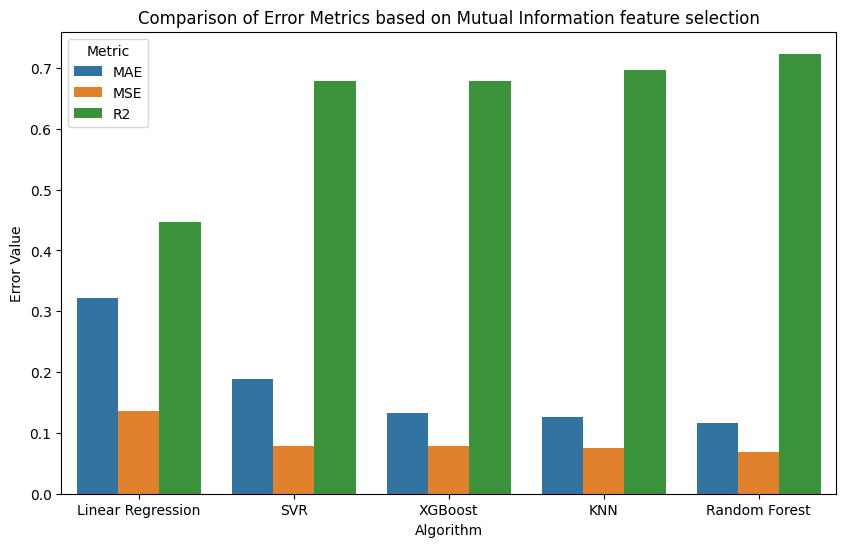

In [58]:
# Metrics dictionary populated from model evaluations
metrics = {
    'Algorithm': ['Linear Regression', 'SVR', 'XGBoost', 'KNN', 'Random Forest'],
    'MAE': [0.3216096072324951,0.18785941254973065,0.13321664285996185,0.1259259259259259,0.115761316872428],  
    'MSE': [0.13587933898326518,0.07879406663128737, 0.07895606668783368,0.0745679012345679,0.06784238683127572],  
    'R2': [0.4462705943669547,0.6789019433739898,0.6782417679882753,0.6961242236024845,0.7235317391304348]    
}

# Convert the metrics dictionary to a DataFrame
metrics_df = pd.DataFrame(metrics)

# Melt the DataFrame for easier plotting
metrics_melted = metrics_df.melt(id_vars='Algorithm', var_name='Metric', value_name='Value')

# Create the bar graph
plt.figure(figsize=(10, 6))
sns.barplot(data=metrics_melted, x='Algorithm', y='Value', hue='Metric')
plt.title('Comparison of Error Metrics based on Mutual Information feature selection')
plt.ylabel('Error Value')
plt.xlabel('Algorithm')
plt.legend(title='Metric')
plt.show()

C:\Users\Kalana Dissanayake\AppData\Local\Temp\ipykernel_11636\305178278.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=Acc_melted, x='Algorithm', y='Value', palette='Set1')


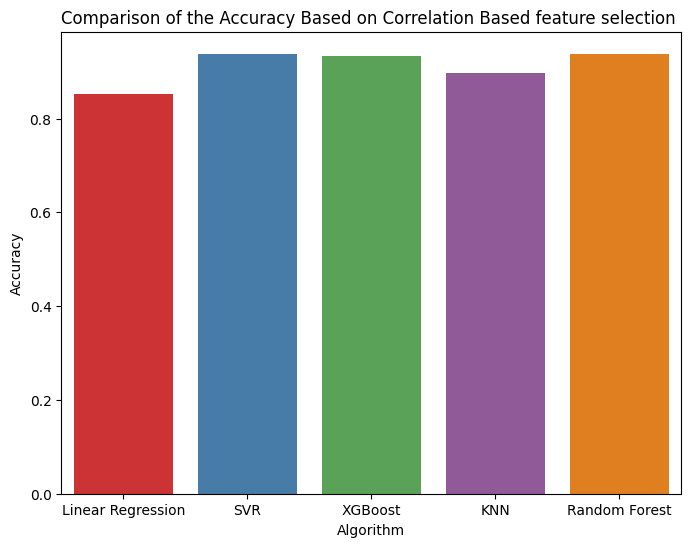

In [16]:
# Accuracy for model evaluations
Acc = {
    'Algorithm': ['Linear Regression', 'SVR', 'XGBoost', 'KNN', 'Random Forest'],
    'Accuracy': [0.8518518518518519,0.9382716049382716,0.934156378600823,0.897119341563786,0.9382716049382716],  
}

# Convert the metrics dictionary to a DataFrame
Acc_df = pd.DataFrame(Acc)

# Melt the DataFrame for easier plotting
Acc_melted = Acc_df.melt(id_vars='Algorithm', value_name='Value')

# Create the bar graph
plt.figure(figsize=(8, 6))
sns.barplot(data=Acc_melted, x='Algorithm', y='Value', palette='Set1')
plt.title('Comparison of the Accuracy Based on Correlation Based feature selection ')
plt.ylabel('Accuracy')
plt.xlabel('Algorithm')
plt.show()

C:\Users\Kalana Dissanayake\AppData\Local\Temp\ipykernel_13188\4042361970.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=Acc_melted, x='Algorithm', y='Value', palette='Set1')


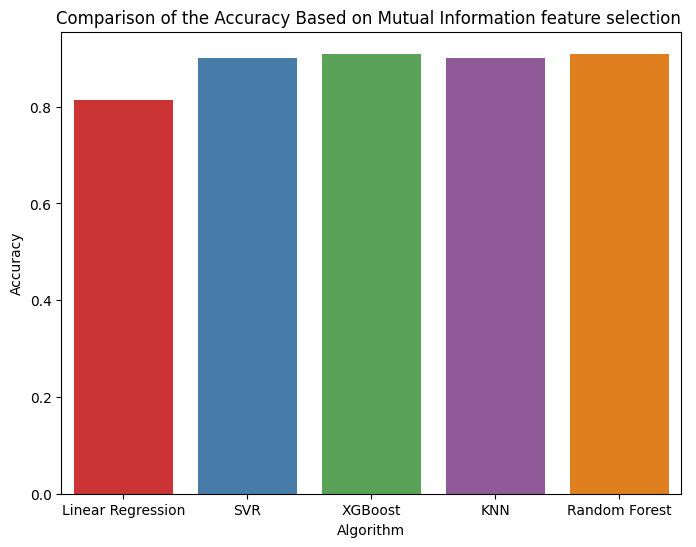

In [71]:
# Accuracy for model evaluations
Acc = {
    'Algorithm': ['Linear Regression', 'SVR', 'XGBoost', 'KNN', 'Random Forest'],
    'Accuracy': [0.8148148148148148,0.9012345679012346, 0.9094650205761317,0.9012345679012346,0.9094650205761317],  
}

# Convert the metrics dictionary to a DataFrame
Acc_df = pd.DataFrame(Acc)

# Melt the DataFrame for easier plotting
Acc_melted = Acc_df.melt(id_vars='Algorithm', value_name='Value')

# Create the bar graph
plt.figure(figsize=(8, 6))
sns.barplot(data=Acc_melted, x='Algorithm', y='Value', palette='Set1')
plt.title('Comparison of the Accuracy Based on Mutual Information feature selection ')
plt.ylabel('Accuracy')
plt.xlabel('Algorithm')
plt.show()

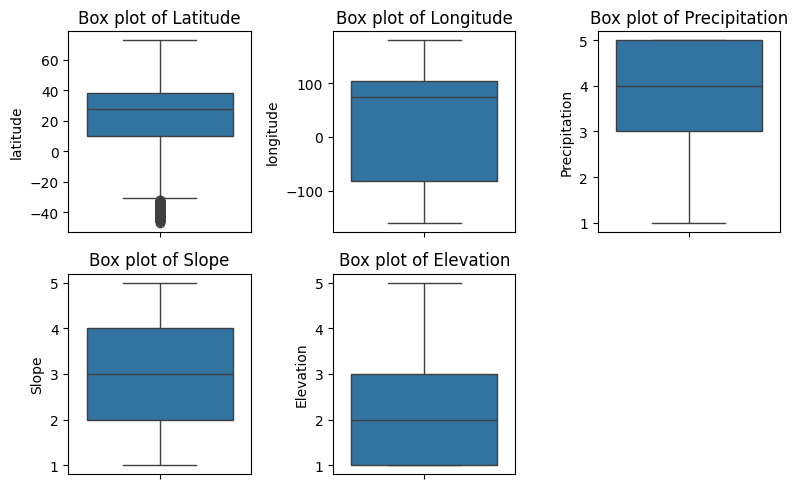

In [17]:
# Plot Box plots
plt.figure(figsize=(8, 5))

# Box plot for latitude
plt.subplot(2, 3, 1)
sns.boxplot(data=combined_features['latitude'])
plt.title('Box plot of Latitude')

# Box plot for longitude
plt.subplot(2, 3, 2)
sns.boxplot(data=combined_features['longitude'])
plt.title('Box plot of Longitude')

# Box plot for Precipitation
plt.subplot(2, 3, 3)
sns.boxplot(data=combined_features['Precipitation'])
plt.title('Box plot of Precipitation')

# Box plot for Slope
plt.subplot(2, 3, 4)
sns.boxplot(data=combined_features['Slope'])
plt.title('Box plot of Slope')

# Box plot for Elevation
plt.subplot(2, 3, 5)
sns.boxplot(data=combined_features['Elevation'])
plt.title('Box plot of Elevation')

plt.tight_layout()
plt.show()

In [22]:
from lightgbm import LGBMRegressor


# Adding LightGBM and CatBoost to the models dictionary
models.update({
    'LightGBM': LGBMRegressor(),
   
})

# Evaluate models using correlation-based features
results_corr = evaluate_models(X_corr_train, X_corr_test, y_corr_train, y_corr_test, preprocessor_corr)

# Evaluate models using mutual information-based features
results_mi = evaluate_models(X_mi_train, X_mi_test, y_mi_train, y_mi_test, preprocessor_mi)
print("Results using Correlation-based Features")
pprint(results_corr)
print("Results using Mutual Information-based Features")
pprint(results_mi)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000130 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 562
[LightGBM] [Info] Number of data points in the train set: 969, number of used features: 9
[LightGBM] [Info] Start training from score 0.517028
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000164 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1037
[LightGBM] [Info] Number of data points in the train set: 969, number of used features: 5
[LightGBM] [Info] Start training from score 0.517028
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No

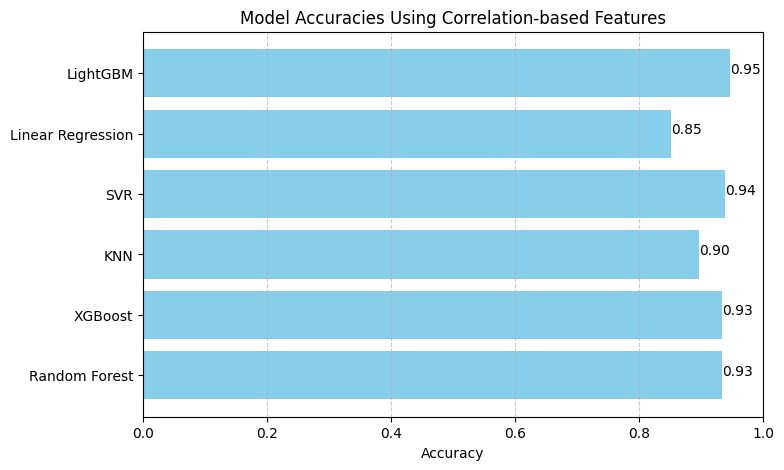

In [25]:
# Extract model names and accuracies
model_names = list(results_corr.keys())
accuracies = [results_corr[model]['Accuracy'] for model in model_names]

# Create a bar plot
plt.figure(figsize=(8, 5))
plt.barh(model_names, accuracies, color='skyblue')
plt.xlabel('Accuracy')
plt.title('Model Accuracies Using Correlation-based Features')
plt.xlim(0, 1)
plt.grid(axis='x', linestyle='--', alpha=0.7)

# Add accuracy values on the bars
for index, value in enumerate(accuracies):
    plt.text(value, index, f"{value:.2f}")

plt.show()


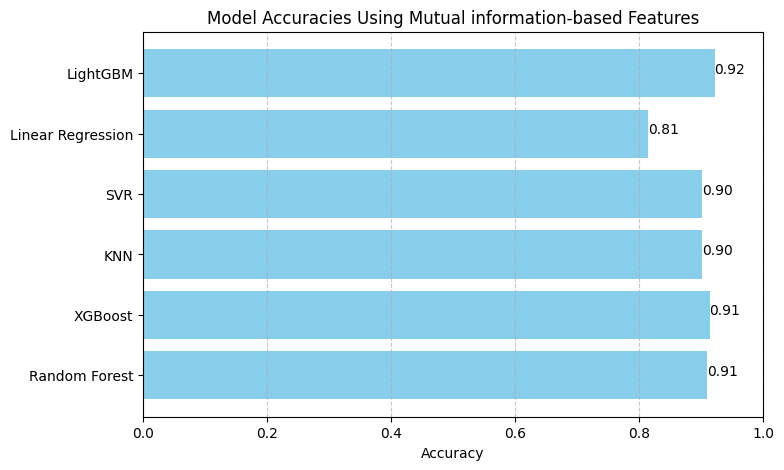

In [24]:
# Extract model names and accuracies
model_names = list(results_mi.keys())
accuracies = [results_mi[model]['Accuracy'] for model in model_names]

# Create a bar plot
plt.figure(figsize=(8, 5))
plt.barh(model_names, accuracies, color='skyblue')
plt.xlabel('Accuracy')
plt.title('Model Accuracies Using Mutual information-based Features')
plt.xlim(0, 1)
plt.grid(axis='x', linestyle='--', alpha=0.7)

# Add accuracy values on the bars
for index, value in enumerate(accuracies):
    plt.text(value, index, f"{value:.2f}")

plt.show()
